In [1]:
import deeplake
from matplotlib import pyplot as plt
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.metrics import accuracy, specificity
from Network.Unet import Custom2DUnet
from torch.nn.functional import one_hot
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np
import random
def seeding(num):
    torch.manual_seed(num)
    torch.cuda.manual_seed(num)
    torch.cuda.manual_seed_all(num)
    np.random.seed(num)
    random.seed(num)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = True

seeding(2025)
skip = False

/home/taehwan/MICCAI/.venv/lib/python3.12/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.1.10) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
/home/taehwan/MICCAI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = deeplake.load("hub://activeloop/drive-test")
visualset = deeplake.load("hub://activeloop/drive-train")
testloader = torch.utils.data.DataLoader(dataset, 16, False, collate_fn=lambda x:x)
dataset[0]

hub://activeloop/drive-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/drive-test
hub://activeloop/drive-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/drive-train


Dataset(path='hub://activeloop/drive-test', read_only=True, index=Index([0]), tensors=['rgb_images', 'masks'])

In [3]:
diceLoss = smp.losses.DiceLoss(
   mode="binary",          # For multi-class segmentation
   classes=None,               # Compute the loss for all classes
   log_loss=False,             # Do not use log version of Dice loss
   from_logits=True,           # Model outputs are raw logits
   smooth=1e-5,                # A small smoothing factor for stability
   ignore_index=None,          # Don't ignore any classes
   eps=1e-7                    # Epsilon for numerical stability
)
class Hausdolf95(torch.nn.Module):
    def __init__(self):
        super(Hausdolf95, self).__init__()
        self.distancef = torch.nn.PairwiseDistance()
    def distance(self, x, y):
        return self.distancef(x, y)
        
    def forward(self, x, y):
        maximum_d=torch.max(self.distance(x, y))
        return maximum_d
hausdolf95 = Hausdolf95()
jaccardf = smp.losses.JaccardLoss(
   mode="binary",          # For multi-class segmentation
   classes=None,               # Compute the loss for all classes
   log_loss=False,             # Do not use log version of Dice loss
   from_logits=True,           # Model outputs are raw logits
   smooth=1e-5,                # A small smoothing factor for stability          
   eps=1e-7
)
def evaluation(net, loader, diceLoss, HF95, jaccard,DEVICE):
    net.eval()
    net.to(DEVICE)
    dicef= diceLoss.to(DEVICE)
    hf95f = HF95.to(DEVICE)
    jaccardf = jaccard.to(DEVICE)
    dice = 0
    hf95 = 0
    jacc = 0
    acc = 0
    spec = 0
    length = len(loader)
    for sample in loader:
        X= torch.stack([torch.Tensor(s["rgb_images"].numpy()).permute(-1,0,1) for s in sample], 0)
        Y= torch.stack([torch.where(torch.from_numpy(s['masks'].numpy()).squeeze()[...,0], 0.0, 1.0).type(torch.int64) for s in sample], 0)
        out = net(X.type(torch.float32).to(DEVICE))
        jacc += (1-jaccardf(out.squeeze(), Y.squeeze().type(torch.int64).to(DEVICE))).item()
        dice += (1-dicef(out.squeeze(), Y.squeeze().type(torch.int64).to(DEVICE))).item()
        hf95 += hf95f(out.squeeze(), Y.type(torch.float32).to(DEVICE)).item()
        out = (out>0.15).type(torch.int32).to(DEVICE)
        acc += accuracy(out.squeeze()*Y.to(DEVICE), (1-out).squeeze()*Y.to(DEVICE),out.squeeze()*(1-Y).to(DEVICE),(1-out).squeeze()*(1-Y).to(DEVICE)).mean().item()
        spec += specificity(out.squeeze()*Y.to(DEVICE), (1-out).squeeze()*Y.to(DEVICE), out.squeeze()*(1-Y).to(DEVICE), (1-out).squeeze()*(1-Y).to(DEVICE)).mean().item()
    return {"dice": dice/length, "hf95":hf95/length, 'jaccard': jacc/length, 'accuracy': acc/length, "specificity": spec/length}

In [4]:
if not skip:
    net = Custom2DUnet(3, 1, True, 4, "cr", num_groups=4)
    net.load_state_dict(torch.load('./Models/CentralDRIVE/net.pt'))
    net.float()
    net.to(DEVICE)
    print("model is ready")
    print(evaluation(net, testloader, diceLoss, hausdolf95, jaccardf, DEVICE))

/tmp/ipykernel_1399089/3996017110.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('./Models/CentralDRIVE/net.pt'))


model is ready
{'dice': 0.7233637571334839, 'hf95': 12.966182231903076, 'jaccard': 0.5666321218013763, 'accuracy': 0.6990729868412018, 'specificity': 0.9902523756027222}


In [5]:
if not skip:
    net = Custom2DUnet(3, 1, True, 4, "cr", num_groups=4)
    net.load_state_dict(torch.load('./Models/FedAvgDRIVE/net.pt'))
    net.float()
    net.to(DEVICE)
    print("model is ready")
    print(evaluation(net, testloader, diceLoss, hausdolf95, jaccardf, DEVICE))

/tmp/ipykernel_1399089/1466659896.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('./Models/FedAvgDRIVE/net.pt'))


model is ready
{'dice': 0.7281927466392517, 'hf95': 11.907052516937256, 'jaccard': 0.5725654661655426, 'accuracy': 0.6879020035266876, 'specificity': 1.0}


In [6]:
if not skip:
    net = Custom2DUnet(3, 1, True, 4, "cr", num_groups=4)
    net.load_state_dict(torch.load('./Models/FedPIDDRIVE/net.pt'))
    net.float()
    net.to(DEVICE)
    print("model is ready")
    print(evaluation(net, testloader, diceLoss, hausdolf95, jaccardf, DEVICE))

/tmp/ipykernel_1399089/4033665747.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('./Models/FedPIDDRIVE/net.pt'))


model is ready
{'dice': 0.7281927466392517, 'hf95': 11.907050609588623, 'jaccard': 0.5725654363632202, 'accuracy': 0.6879020035266876, 'specificity': 1.0}


In [7]:
if not skip:
    net = Custom2DUnet(3, 1, True, 4, "cr", num_groups=4)
    net.load_state_dict(torch.load('./Models/FedLWRDRIVE/net.pt'))
    net.float()
    net.to(DEVICE)
    print("model is ready")
    print(evaluation(net, testloader, diceLoss, hausdolf95, jaccardf, DEVICE))

/tmp/ipykernel_1399089/2555081909.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('./Models/FedLWRDRIVE/net.pt'))


model is ready
{'dice': 0.7281927466392517, 'hf95': 11.907053470611572, 'jaccard': 0.5725654363632202, 'accuracy': 0.6879020035266876, 'specificity': 1.0}


In [8]:
if not skip:
    net = Custom2DUnet(3, 1, True, 4, "cr", num_groups=4)
    net.load_state_dict(torch.load('./Models/FedRefDRIVE/net.pt'))
    net.float()
    net.to(DEVICE)
    print("model is ready")
    print(evaluation(net, testloader, diceLoss, hausdolf95, jaccardf, DEVICE))

/tmp/ipykernel_1399089/2641275200.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('./Models/FedRefDRIVE/net.pt'))


model is ready
{'dice': 0.7281927466392517, 'hf95': 11.907052516937256, 'jaccard': 0.5725654363632202, 'accuracy': 0.6879020035266876, 'specificity': 1.0}


In [100]:
def minmaxNorm(tensor):
    return (tensor-tensor.min())/(tensor.max()-tensor.min())

def visualization(img, label, pred, threshold=0.7):
    fig, ax =plt.subplots(1,3)
    ax[0].imshow(img.squeeze())
    ax[1].imshow((label.squeeze()).astype("uint8"), cmap="gray")
    print(pred.max())
    ax[2].imshow((minmaxNorm(torch.clip(pred, 0))>threshold).squeeze().cpu().detach().numpy(), cmap="gray")
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()
    fig.tight_layout()
    fig.show()

In [101]:
indx=7

/tmp/ipykernel_312015/3688275202.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('./Models/CentralDRIVE/net.pt'))


model is ready
tensor(5.8789, device='cuda:0', grad_fn=<MaxBackward1>)


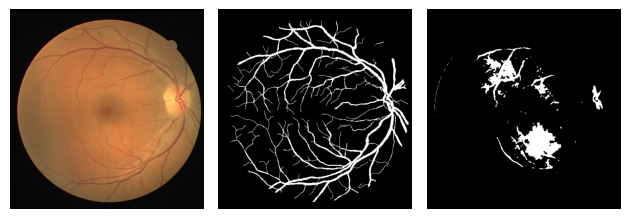

In [111]:
net = Custom2DUnet(3, 1, True, 4, "cr", num_groups=4)
net.load_state_dict(torch.load('./Models/CentralDRIVE/net.pt'))
net.float()
net.to(DEVICE)
print("model is ready")
img = visualset[indx]["rgb_images"].numpy()
label= np.where(visualset[indx]['manual_masks/mask'].numpy(), 0.0,1.0)[...,0].squeeze()
pred = net(torch.Tensor(img).permute(-1,0,1).unsqueeze(0).to(DEVICE))
visualization(img,label, pred, 0.55)

model is ready
tensor(141.6097, device='cuda:0', grad_fn=<MaxBackward1>)


/tmp/ipykernel_312015/3229563335.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('./Models/FedAvgDRIVE/net.pt'))


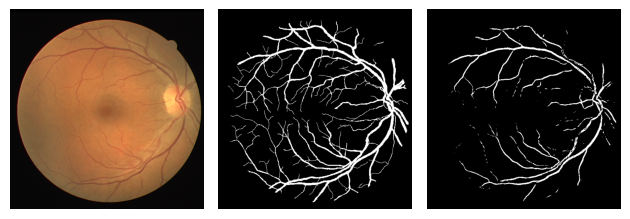

In [103]:
net = Custom2DUnet(3, 1, True, 4, "cr", num_groups=4)
net.load_state_dict(torch.load('./Models/FedAvgDRIVE/net.pt'))
net.float()
net.to(DEVICE)
print("model is ready")
img = visualset[indx]["rgb_images"].numpy()
label= np.where(visualset[indx]['manual_masks/mask'].numpy(), 0.0,1.0)[...,0].squeeze()
pred = net(torch.Tensor(img).permute(-1,0,1).unsqueeze(0).to(DEVICE))
visualization(img,label, pred, 0.15)

model is ready
tensor(0.8715, device='cuda:0', grad_fn=<MaxBackward1>)


/tmp/ipykernel_312015/3532279862.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('./Models/FedPIDDRIVE/net.pt'))


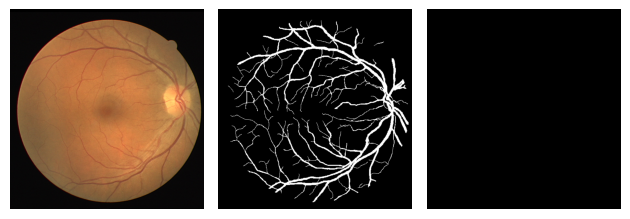

In [104]:
net = Custom2DUnet(3, 1, True, 4, "cr", num_groups=4)
net.load_state_dict(torch.load('./Models/FedPIDDRIVE/net.pt'))
net.float()
net.to(DEVICE)
print("model is ready")
img = visualset[indx]["rgb_images"].numpy()
label= np.where(visualset[indx]['manual_masks/mask'].numpy(), 0.0,1.0)[...,0].squeeze()
pred = net(torch.Tensor(img).permute(-1,0,1).unsqueeze(0).to(DEVICE))
visualization(img,label, pred, 1)

model is ready
tensor(191.7068, device='cuda:0', grad_fn=<MaxBackward1>)


/tmp/ipykernel_312015/3384851298.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('./Models/FedLWRDRIVE/net.pt'))


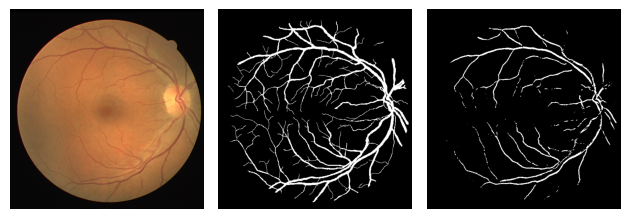

In [105]:
net = Custom2DUnet(3, 1, True, 4, "cr", num_groups=4)
net.load_state_dict(torch.load('./Models/FedLWRDRIVE/net.pt'))
net.float()
net.to(DEVICE)
print("model is ready")
img = visualset[indx]["rgb_images"].numpy()
label= np.where(visualset[indx]['manual_masks/mask'].numpy(), 0.0,1.0)[...,0].squeeze()
pred = net(torch.Tensor(img).permute(-1,0,1).unsqueeze(0).to(DEVICE))
visualization(img,label, pred, 0.15)

model is ready
tensor(253.3306, device='cuda:0', grad_fn=<MaxBackward1>)


/tmp/ipykernel_312015/3278297731.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('./Models/FedRefDRIVE/net.pt'))


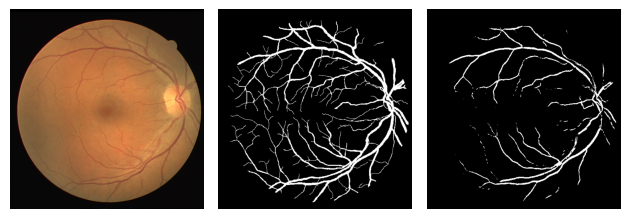

In [106]:
net = Custom2DUnet(3, 1, True, 4, "cr", num_groups=4)
net.load_state_dict(torch.load('./Models/FedRefDRIVE/net.pt'))
net.float()
net.to(DEVICE)
print("model is ready")
img = visualset[indx]["rgb_images"].numpy()
label= np.where(visualset[indx]['manual_masks/mask'].numpy(), 0.0,1.0)[...,0].squeeze()
pred = net(torch.Tensor(img).permute(-1,0,1).unsqueeze(0).to(DEVICE))
visualization(img,label, pred, 0.15)

Text(0.5, 0, 'ROUND')

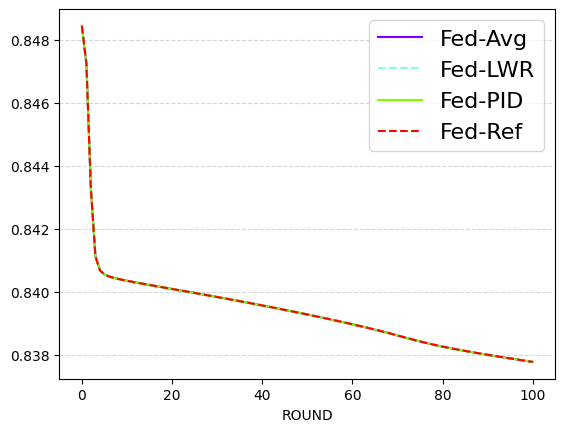

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
 
fedavgframe = pd.read_csv('Result/fedavg/FedAvg_drive.csv')
fedpidframe = pd.read_csv('Result/fedpid/FedPID_drive.csv')
fedlwrframe = pd.read_csv('Result/fedlwr/FedLWR_drive.csv')
fedrefframe = pd.read_csv("Result/fedref/FedRef_drive.csv")

length = min([len(fedavgframe), len(fedpidframe), len(fedlwrframe), len(fedrefframe)])
plt.plot(fedavgframe['loss'].to_numpy()[:length], color=(0.5,0,1), label= "Fed-Avg", marker= "", linestyle="-")
plt.plot(fedlwrframe['loss'].to_numpy()[:length], color=(0.5,1,0.9), label= "Fed-LWR", marker= "", linestyle="--")
plt.plot(fedpidframe['loss'].to_numpy()[:length], color=(0.5,1,0), label= "Fed-PID", marker= "", linestyle="-")
plt.plot(fedrefframe['loss'].to_numpy()[:length], color=(1,0,0), label= "Fed-Ref", marker= "", linestyle="--")
plt.grid(True, axis="y", alpha=0.5, linestyle="--")
plt.legend(fontsize=16)
# plt.ylim(top=0.84)
plt.xlabel("round".upper())
# plt.ylabel("Loss")

Text(0.5, 0, 'ROUND')

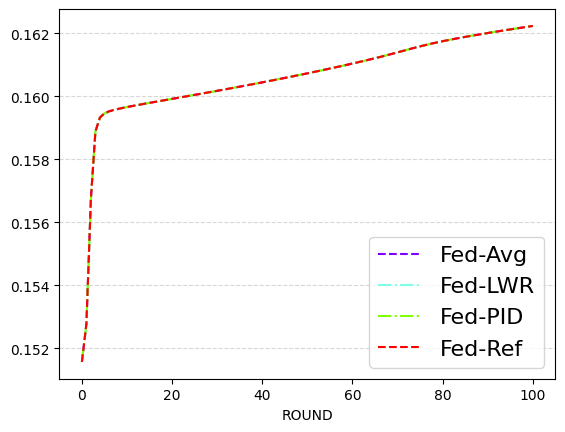

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
 
fedavgframe = pd.read_csv('Result/fedavg/FedAvg_drive.csv')
fedpidframe = pd.read_csv('Result/fedpid/FedPID_drive.csv')
fedlwrframe = pd.read_csv('Result/fedlwr/FedLWR_drive.csv')
fedrefframe = pd.read_csv("Result/fedref/FedRef_drive.csv")
length = min([len(fedavgframe), len(fedpidframe), len(fedlwrframe), len(fedrefframe)])
plt.plot(fedavgframe['mDice'].to_numpy()[:length], color=(0.5,0,1), label= "Fed-Avg", marker= "", linestyle="--")
plt.plot(fedlwrframe['mDice'].to_numpy()[:length], color=(0.5,1,0.9), label= "Fed-LWR", marker= "", linestyle="-.")
plt.plot(fedpidframe['mDice'].to_numpy()[:length], color=(0.5,1,0), label= "Fed-PID", marker= "", linestyle="-.")
plt.plot(fedrefframe['mDice'].to_numpy()[:length], color=(1,0,0), label= "Fed-Ref", marker= "", linestyle="--")
plt.grid(True, axis="y", alpha=0.5, linestyle="--")
plt.legend(fontsize=16)
plt.xlabel("round".upper())
# plt.ylabel("DiceScore")

Text(0.5, 0, 'ROUND')

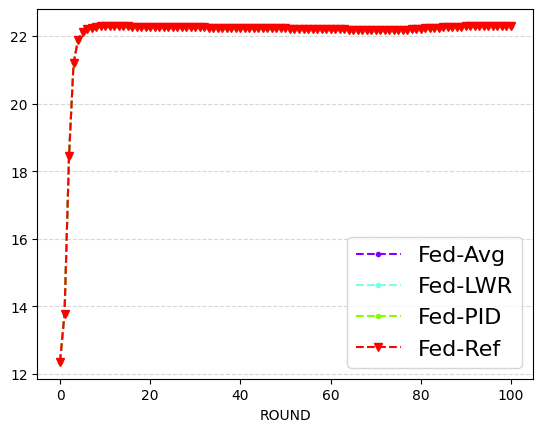

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
 
fedavgframe = pd.read_csv('Result/fedavg/FedAvg_drive.csv')
fedpidframe = pd.read_csv('Result/fedpid/FedPID_drive.csv')
fedlwrframe = pd.read_csv('Result/fedlwr/FedLWR_drive.csv')
fedrefframe = pd.read_csv("Result/fedref/FedRef_drive.csv")
length = min([len(fedavgframe), len(fedpidframe), len(fedlwrframe), len(fedrefframe)])
plt.plot(fedavgframe['mHF95'].to_numpy()[:length], color=(0.5,0,1), label= "Fed-Avg", marker= ".", linestyle="--")
plt.plot(fedlwrframe['mHF95'].to_numpy()[:length], color=(0.5,1,0.9), label= "Fed-LWR", marker= ".", linestyle="--")
plt.plot(fedpidframe['mHF95'].to_numpy()[:length], color=(0.5,1,0), label= "Fed-PID", marker= ".", linestyle="--")
plt.plot(fedrefframe['mHF95'].to_numpy()[:length], color=(1,0,0), label= "Fed-Ref", marker= "v", linestyle="--")
plt.grid(True, axis="y", alpha=0.5, linestyle="--")
plt.legend(fontsize=16)
plt.xlabel("round".upper())
# plt.ylabel("Housdorff Distance")